In [1]:
! pip install onnxruntime-training

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 87.5 MB/s eta 0:00:00
  Created wheel for cerberus: filename=Cerberus-1.3.4-py3-none-any.whl size=58193 sha256=8a7772a8a238e4a75ab3e461e7914b53dfc168ca3a2574239fae5875929addad
  Stored in directory: /root/.cache/pip/wheels/cd/1f/a3/075fbe965309e96fbbd681d8f1829b10c9da8afb60ee3d137d
Successfully built cerberus


In [2]:
! git clone https://github.com/xionghaoo/onnxtrain.git
%cd onnxtrain
# ! git clone https://github.com/microsoft/onnxruntime-training-examples.git
# %cd onnxruntime-training-examples/on_device_training/mobile/android/c-cpp/

Cloning into 'onnxtrain'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 130 (delta 3), reused 129 (delta 2), pack-reused 0
Receiving objects: 100% (130/130), 11.02 MiB | 27.85 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/onnxtrain


In [3]:
import torch
import torchvision

model = torchvision.models.mobilenet_v2(
   weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)

# The original model is trained on imagenet which has 1000 classes.
# For our image classification scenario, we need to classify among 4 categories.
# So we need to change the last layer of the model to have 4 outputs.
model.classifier[1] = torch.nn.Linear(1280, 5)

# Export the model to ONNX.
model_name = "mobilenetv2"
torch.onnx.export(model, torch.randn(1, 3, 224, 224),
                  f"training_artifacts/{model_name}.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}})

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 97.3MB/s]


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [4]:
import onnx
from onnxruntime.training import artifacts

# Load the onnx model.
onnx_model = onnx.load(f"training_artifacts/{model_name}.onnx")

requires_grad = ["classifier.1.weight", "classifier.1.bias"]
frozen_params = [
   param.name
   for param in onnx_model.graph.initializer
   if param.name not in requires_grad
]


# Generate the training artifacts.
artifacts.generate_artifacts(
   onnx_model,
   requires_grad=requires_grad,
   frozen_params=frozen_params,
   loss=artifacts.LossType.CrossEntropyLoss,
   optimizer=artifacts.OptimType.AdamW,
   artifact_directory="training_artifacts"
)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_validation.py:114: UserWarning: WARNING: failed to get cudart_version from onnxruntime build info.
  warnings.warn("WARNING: failed to get cudart_version from onnxruntime build info.")


开始训练

In [5]:
import glob

# load the dataset files into a dictionary
def load_dataset_files():
    animals = {
        "dog": [],
        "cat": [],
        "elephant": [],
        "cow": [],
        "airpod": []
    }

    for animal in animals:
        animals[animal] = glob.glob(
            f"data/images/{animal}/*")

    return animals

animals = load_dataset_files()

In [6]:
import numpy as np

# Preprocess the images and convert to tensors as expected by the model
# Makes the image a square and resizes it to 224x224 as is expected by
# the mobilenetv2 model
# Normalize the image by subtracting the mean (0.485, 0.456, 0.406) and
# dividing by the standard deviation (0.229, 0.224, 0.225)
def image_file_to_tensor(file):
    from PIL import Image

    image = Image.open(file)
    width, height = image.size
    if width > height:
        left = (width - height) // 2
        right = (width + height) // 2
        top = 0
        bottom = height
    else:
        left = 0
        right = width
        top = (height - width) // 2
        bottom = (height + width) // 2
    image = image.crop((left, top, right, bottom)).resize((224, 224))

    pix = np.transpose(np.array(image, dtype=np.float32), (2, 0, 1))
    pix = pix / 255.0
    pix[0] = (pix[0] - 0.485) / 0.229
    pix[1] = (pix[1] - 0.456) / 0.224
    pix[2] = (pix[2] - 0.406) / 0.225
    return pix

In [7]:
# Training metadata
dog, cat, elephant, cow, airpod = "dog", "cat", "elephant", "cow", "airpod" # labels
label_to_id_map = {
    "dog": 0,
    "cat": 1,
    "elephant": 2,
    "cow": 3,
    "airpod": 4
} # label to index mapping

num_samples_per_class = 20
num_epochs = 5

In [8]:
import onnxruntime.training.api as orttraining

# Instantiate the training session by defining the checkpoint state, module, and optimizer
# The checkpoint state contains the state of the model parameters at any given time.
checkpoint_state = orttraining.CheckpointState.load_checkpoint(
    "training_artifacts/checkpoint")

model = orttraining.Module(
    "training_artifacts/training_model.onnx",
    checkpoint_state,
    "training_artifacts/eval_model.onnx",
)

optimizer = orttraining.Optimizer(
    "training_artifacts/optimizer_model.onnx", model
)

# Training loop
for epoch in range(num_epochs):
    model.train()
    loss = 0
    for index in range(num_samples_per_class):
        batch = []
        labels = []
        for animal in animals:
            batch.append(image_file_to_tensor(animals[animal][index]))
            labels.append(label_to_id_map[animal])
        batch = np.stack(batch)
        labels = np.array(labels, dtype=np.int64)

        # ort training api - training model execution outputs the training loss and the parameter gradients
        loss += model(batch, labels)
        # ort training api - update the model parameters by taking a step in the direction of the gradients
        optimizer.step()
        # ort training api - reset the gradients to zero so that new gradients can be computed in the next run
        model.lazy_reset_grad()

    print(f"Epoch {epoch+1} Loss {loss/num_samples_per_class}")

Epoch 1 Loss 1.1493447810411452
Epoch 2 Loss 0.45710420310497285
Epoch 3 Loss 0.22294753715395926
Epoch 4 Loss 0.13529596403241156
Epoch 5 Loss 0.09413395598530769


In [11]:
from onnxruntime import InferenceSession
from onnxruntime.capi import _pybind_state as C

from IPython.display import Image, display

# ort training api - export the model for so that it can be used for inferencing
model.export_model_for_inferencing("inference_artifacts/inference.onnx", ["output"])

# Run inference on the exported model
session = InferenceSession("inference_artifacts/inference.onnx", providers=C.get_available_providers())

def softmax(logits):
    return (np.exp(logits)/np.exp(logits).sum())

def predict(test_file, test_name):
    logits = session.run(["output"], {"input": np.stack([image_file_to_tensor(test_file)])})
    probabilities = softmax(logits) * 100
    display(Image(filename=test_file))
    print_prediction(probabilities, test_name)

def print_prediction(prediction, test_name):
    print(f"test\t{dog}\t{cat}\t{elephant}\t{cow}\t{airpod}")
    print("-------------------------------------------------")
    print(f"{test_name}\t{prediction[0][0][0]:.2f}\t{prediction[0][0][1]:.2f}\t{prediction[0][0][2]:.2f}\t\t{prediction[0][0][3]:.2f}\t\t{prediction[0][0][4]:.2f}")

EP Error /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:121 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, ERRTYPE, const char*, const char*, int) [with ERRTYPE = cudaError; bool THRW = true; std::conditional_t<THRW, void, onnxruntime::common::Status> = void] /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:114 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, ERRTYPE, const char*, const char*, int) [with ERRTYPE = cudaError; bool THRW = true; std::conditional_t<THRW, void, onnxruntime::common::Status> = void] CUDA failure 35: CUDA driver version is insufficient for CUDA runtime version ; GPU=0 ; hostname=0ae29ee00dad ; file=/onnxruntime_src/onnxruntime/core/providers/cuda/cuda_execution_provider.cc ; line=238 ; expr=cudaSetDevice(info_.device_id); 

 when using ['CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back

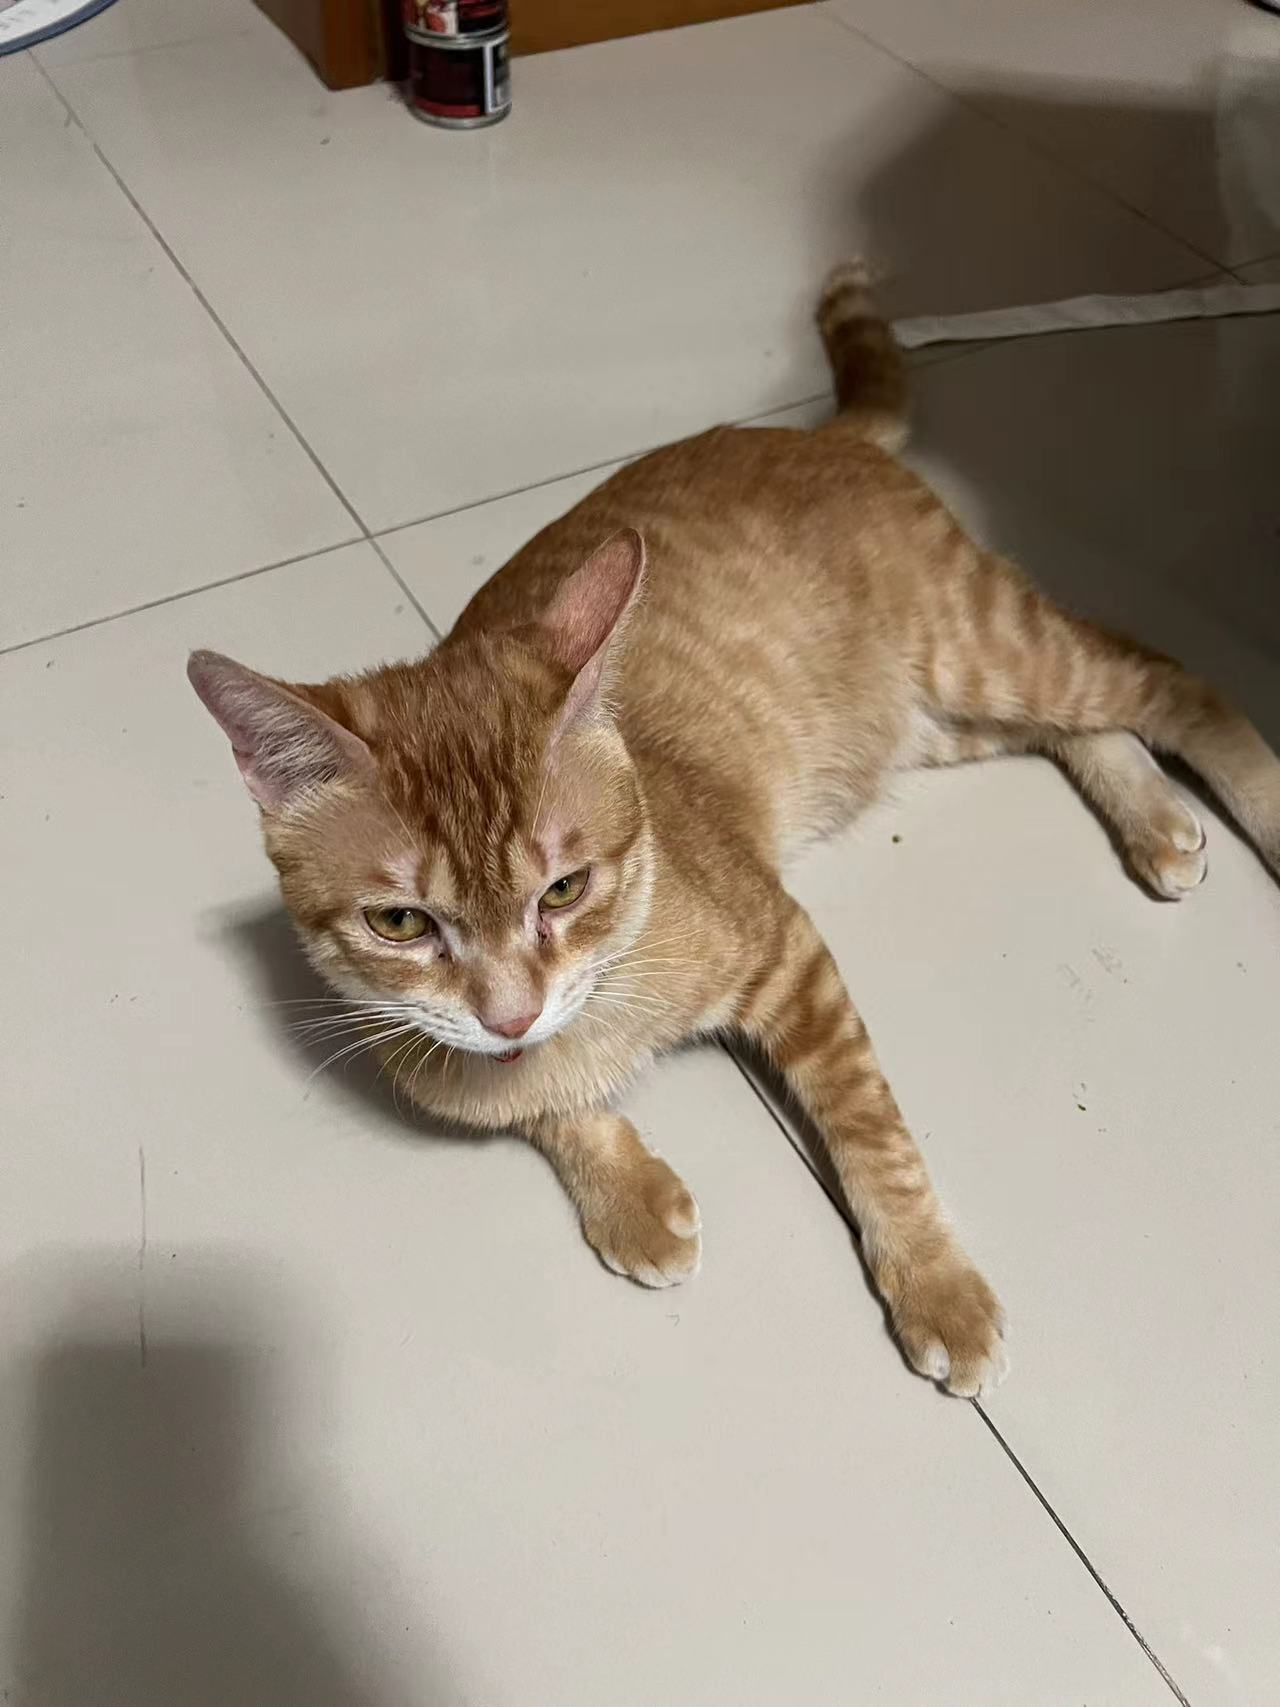

test	dog	cat	elephant	cow	airpod
-------------------------------------------------
test2	1.98	90.78	3.52		1.23		2.48


In [12]:
# Test on sample image (test1.jpg)
predict("inference_artifacts/test2.jpeg", "test2")